In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [2]:
import os

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

fe = FeatureExtractor()

# Iterate through images (Change the path based on your image location)
for img_path in tqdm(os.listdir("Dataset/Flipkart/images")):
    # Extract Features
    feature = fe.extract(img=Image.open('Dataset/Flipkart/images/' + str(img_path)))
    # Save the Numpy array (.npy) on designated path
    feature_path = "Dataset/Flipkart/features/{}.npy".format(str(img_path).replace('.jpg',''))
    np.save(feature_path, feature)

<ipython-input-4-76d58a13e791>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_path in tqdm(os.listdir("Dataset/Flipkart/images")):


  0%|          | 0/18330 [00:00<?, ?it/s]

In [6]:
# Build features DataFrame
features = []
for f in tqdm(os.listdir("Dataset/Flipkart/features")):
  add_feature = np.load("Dataset/Flipkart/features/" + str(f))
  add_feature = pd.DataFrame([add_feature])
  add_feature['image'] = f.replace('.npy','.jpg')

  features.append(add_feature)

features = pd.concat(features, axis=0)
features.to_csv('Dataset/feature_extraction.csv', index=False)

<ipython-input-6-3bcae6f7a391>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(os.listdir("Dataset/Flipkart/features")):


  0%|          | 0/18330 [00:00<?, ?it/s]

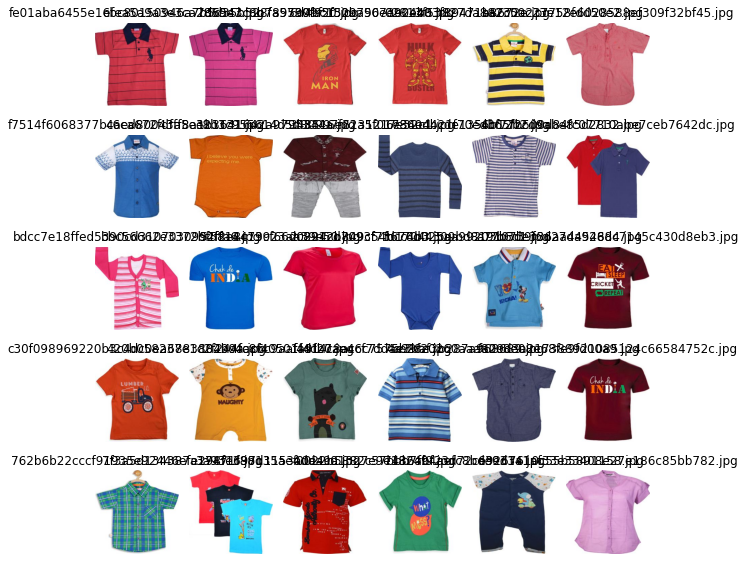

In [7]:
# Insert the image query
img = Image.open("Dataset/Flipkart/images/fe01aba6455e16fea5a9a3e3ca2859e7.jpg")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
features_data = features.copy()
features_data = features_data.drop(columns = ['image'])
features_data = features_data.values
dists = np.linalg.norm(features_data - query, axis=1)

# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
lookalike_imgs = features.iloc[ids,:]['image']
scores = pd.DataFrame({'image': lookalike_imgs,
                       'score': dists[ids]})
scores = scores.reset_index(drop=True)

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores['score'][a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(scores['image'][a])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open('Dataset/Flipkart/images/' + scores['image'][a]))
fig.tight_layout()
plt.show()